# PyTorch Metric Learning
### Example for the TwoStreamMetricLoss trainer
See the documentation [here](https://kevinmusgrave.github.io/pytorch-metric-learning/)

## Install prereqs

In [ ]:
!pip install -q pytorch-metric-learning[with-hooks]
!pip install umap-learn

     |████████████████████████████████| 81kB 5.3MB/s 
     |████████████████████████████████| 35.5MB 90kB/s 
     |████████████████████████████████| 1.1MB 8.1MB/s 


## Import the packages

In [ ]:
%matplotlib inline
import logging

import matplotlib.pyplot as plt
import numpy as np
import record_keeper
import torch
import torch.nn as nn
import torchvision
import umap
from cycler import cycler
from PIL import Image
from torchvision import datasets, transforms

import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning import losses, miners, samplers, testers, trainers
from pytorch_metric_learning.utils import common_functions
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s" % pytorch_metric_learning.__version__)

INFO:root:VERSION 0.9.85


## Create two-stream dataset from CIFAR100

In [ ]:
class CIFAR100TwoStreamDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, anchor_transform, posneg_transform):
        # split by some thresholds here 80% anchors, 20% for posnegs
        lengths = [int(len(dataset) * 0.8), int(len(dataset) * 0.2)]
        self.anchors, self.posnegs = torch.utils.data.random_split(dataset, lengths)

        self.anchor_transform = anchor_transform
        self.posneg_transform = posneg_transform

    def __len__(self):
        return len(self.anchors)

    def __getitem__(self, index):
        anchor, target = self.anchors[index]
        if self.anchor_transform is not None:
            anchor = self.anchor_transform(anchor)

        # now pair this up with an image from the same class in the second stream
        A = np.where(np.array(self.posnegs.dataset.targets) == target)[0]
        posneg_idx = np.random.choice(A[np.in1d(A, self.posnegs.indices)])
        posneg, target = self.posnegs[
            np.where(self.posnegs.indices == posneg_idx)[0][0]
        ]

        if self.posneg_transform is not None:
            posneg = self.posneg_transform(posneg)
        return anchor, posneg, target

##Simple model def

In [ ]:
class MLP(nn.Module):
    # layer_sizes[0] is the dimension of the input
    # layer_sizes[-1] is the dimension of the output
    def __init__(self, layer_sizes, final_relu=False):
        super().__init__()
        layer_list = []
        layer_sizes = [int(x) for x in layer_sizes]
        num_layers = len(layer_sizes) - 1
        final_relu_layer = num_layers if final_relu else num_layers - 1
        for i in range(len(layer_sizes) - 1):
            input_size = layer_sizes[i]
            curr_size = layer_sizes[i + 1]
            if i < final_relu_layer:
                layer_list.append(nn.ReLU(inplace=False))
            layer_list.append(nn.Linear(input_size, curr_size))
        self.net = nn.Sequential(*layer_list)
        self.last_linear = self.net[-1]

    def forward(self, x):
        return self.net(x)

## Initialize models, optimizers and image transforms

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set trunk model and replace the softmax layer with an identity function
trunk = torchvision.models.resnet18(pretrained=True)
trunk_output_size = trunk.fc.in_features
trunk.fc = common_functions.Identity()
trunk = torch.nn.DataParallel(trunk.to(device))

# Set embedder model. This takes in the output of the trunk and outputs 128 dimensional embeddings
embedder = torch.nn.DataParallel(MLP([trunk_output_size, 128]).to(device))

# Set optimizers
trunk_optimizer = torch.optim.Adam(trunk.parameters(), lr=0.00004, weight_decay=0.00005)
embedder_optimizer = torch.optim.Adam(
    embedder.parameters(), lr=0.00004, weight_decay=0.00005
)

# Set the image transforms
train_transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.RandomResizedCrop(scale=(0.16, 1), ratio=(0.75, 1.33), size=64),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


## Initialize the datasets

In [ ]:
# Download and create datasets
original_train = datasets.CIFAR100(
    root="CIFAR100_Dataset", train=True, transform=None, download=True
)
original_val = datasets.CIFAR100(
    root="CIFAR100_Dataset", train=False, transform=None, download=True
)

# splits CIFAR100 into two streams
# 20% of the images will be used as a stream for positives and negatives
# the remaining images are used as anchor images

train_dataset = CIFAR100TwoStreamDataset(
    original_train, anchor_transform=train_transform, posneg_transform=train_transform
)
val_dataset = CIFAR100TwoStreamDataset(
    original_val, anchor_transform=val_transform, posneg_transform=val_transform
)

Extracting CIFAR100_Dataset/cifar-100-python.tar.gz to CIFAR100_Dataset
Files already downloaded and verified


## Create the loss, miner, sampler, and package them into dictionaries

In [ ]:
# Set the loss function
loss = losses.TripletMarginLoss(margin=0.2)

# Set the mining function
miner = miners.TripletMarginMiner(margin=0.2)

# Set the dataloader sampler
sampler = samplers.MPerClassSampler(
    original_train.classes, m=1, length_before_new_iter=len(train_dataset)
)

# Set other training parameters
batch_size = 128
num_epochs = 4

# Package the above stuff into dictionaries.
models = {"trunk": trunk, "embedder": embedder}
optimizers = {
    "trunk_optimizer": trunk_optimizer,
    "embedder_optimizer": embedder_optimizer,
}
loss_funcs = {"metric_loss": loss}
mining_funcs = {"tuple_miner": miner}

In [ ]:
# Remove logs if you want to train with new parameters
!rm -rf example_logs/ example_saved_models/ example_tensorboard/

## Create the training and testing hooks

In [ ]:
record_keeper, _, _ = logging_presets.get_record_keeper(
    "example_logs", "example_tensorboard"
)
hooks = logging_presets.get_hook_container(record_keeper)
dataset_dict = {"val": val_dataset}
model_folder = "example_saved_models"


def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, *args):
    logging.info(
        "UMAP plot for the {} split and label set {}".format(split_name, keyname)
    )
    label_set = np.unique(labels)
    num_classes = len(label_set)
    fig = plt.figure(figsize=(20, 15))
    plt.gca().set_prop_cycle(
        cycler(
            "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]
        )
    )
    half = int(umap_embeddings.shape[0] / 2)
    anchors = umap_embeddings[:half]
    posneg = umap_embeddings[half:]
    labels = labels[:half]
    for i in range(num_classes):
        idx = labels == label_set[i]
        plt.plot(posneg[idx, 0], posneg[idx, 1], "s", markersize=1)
        plt.plot(anchors[idx, 0], anchors[idx, 1], ".", markersize=1)
    plt.show()


# Create the tester
tester = testers.GlobalTwoStreamEmbeddingSpaceTester(
    end_of_testing_hook=hooks.end_of_testing_hook,
    visualizer=umap.UMAP(n_neighbors=50),
    visualizer_hook=visualizer_hook,
    dataloader_num_workers=32,
    accuracy_calculator=AccuracyCalculator(k="max_bin_count"),
)

end_of_epoch_hook = hooks.end_of_epoch_hook(tester, dataset_dict, model_folder)

## Create the trainer

In [ ]:
trainer = trainers.TwoStreamMetricLoss(
    models,
    optimizers,
    batch_size,
    loss_funcs,
    mining_funcs,
    train_dataset,
    sampler=sampler,
    dataloader_num_workers=2,
    end_of_iteration_hook=hooks.end_of_iteration_hook,
    end_of_epoch_hook=end_of_epoch_hook,
)

## Start Tensorboard
(Turn off adblock and other shields)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir example_tensorboard

## Train the model

INFO:root:Initializing dataloader
INFO:root:Initializing dataloader iterator
INFO:root:Done creating dataloader iterator
INFO:root:TRAINING EPOCH 1
total_loss=0.14727: 100%|██████████| 312/312 [04:15<00:00,  1.22it/s]
INFO:root:Evaluating epoch 1
INFO:root:Getting embeddings for the val split
100%|██████████| 250/250 [00:16<00:00, 14.90it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


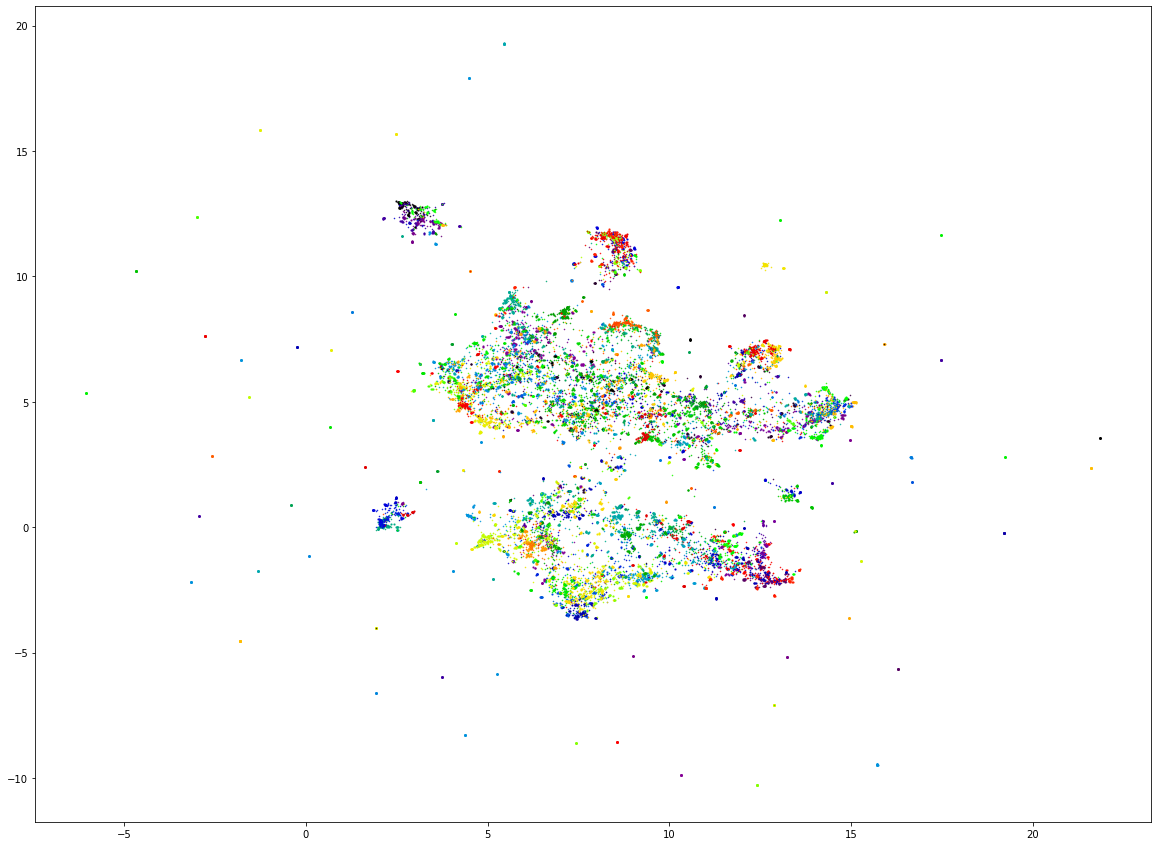

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=91
INFO:root:embedding dimensionality is 128
INFO:root:running k-means clustering with k=100
INFO:root:embedding dimensionality is 128
INFO:root:New best accuracy! 0.11832231353388803
INFO:root:TRAINING EPOCH 2
total_loss=0.13630: 100%|██████████| 312/312 [04:08<00:00,  1.26it/s]
INFO:root:Evaluating epoch 2
INFO:root:Getting embeddings for the val split
100%|██████████| 250/250 [00:17<00:00, 14.49it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


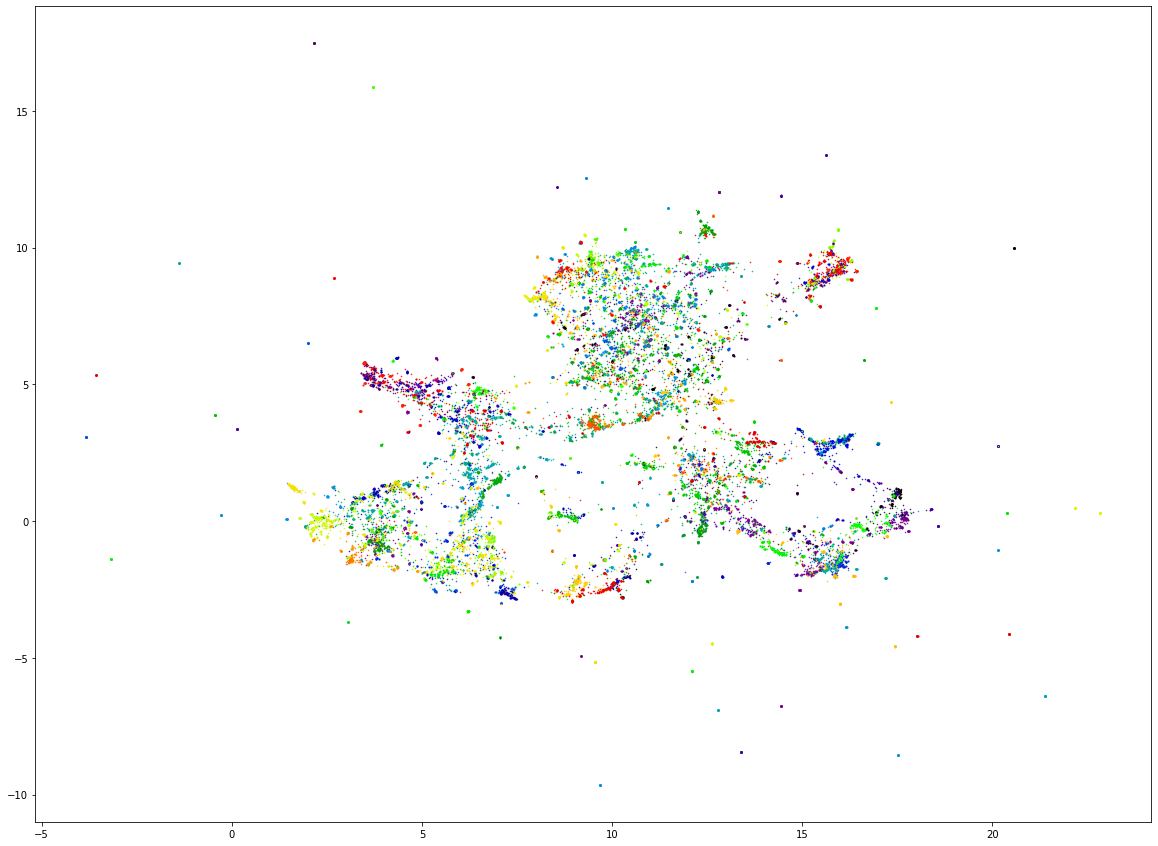

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=91
INFO:root:embedding dimensionality is 128
INFO:root:running k-means clustering with k=100
INFO:root:embedding dimensionality is 128
INFO:root:New best accuracy! 0.1401287447494973
INFO:root:TRAINING EPOCH 3
total_loss=0.12331: 100%|██████████| 312/312 [04:07<00:00,  1.26it/s]
INFO:root:Evaluating epoch 3
INFO:root:Getting embeddings for the val split
100%|██████████| 250/250 [00:17<00:00, 14.47it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


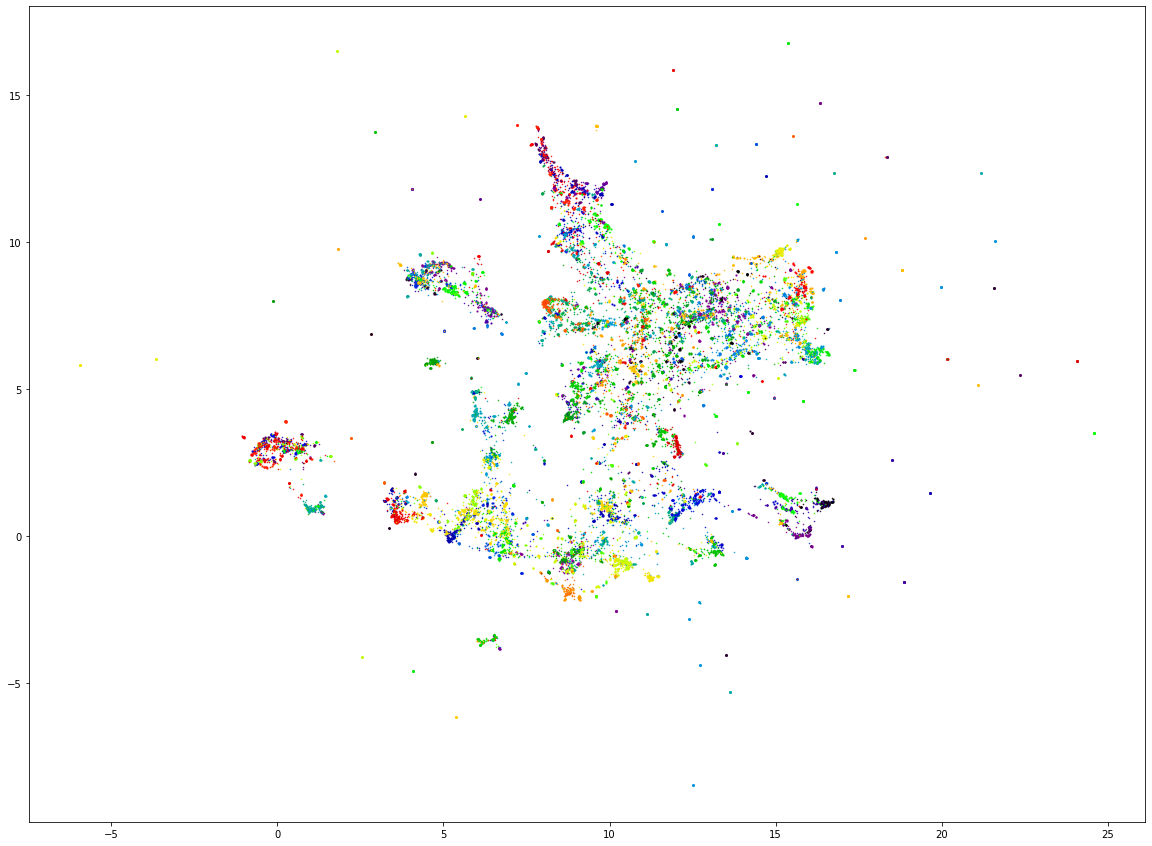

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=91
INFO:root:embedding dimensionality is 128
INFO:root:running k-means clustering with k=100
INFO:root:embedding dimensionality is 128
INFO:root:New best accuracy! 0.14491999230370486
INFO:root:TRAINING EPOCH 4
total_loss=0.12154: 100%|██████████| 312/312 [04:07<00:00,  1.26it/s]
INFO:root:Evaluating epoch 4
INFO:root:Getting embeddings for the val split
100%|██████████| 250/250 [00:17<00:00, 14.48it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


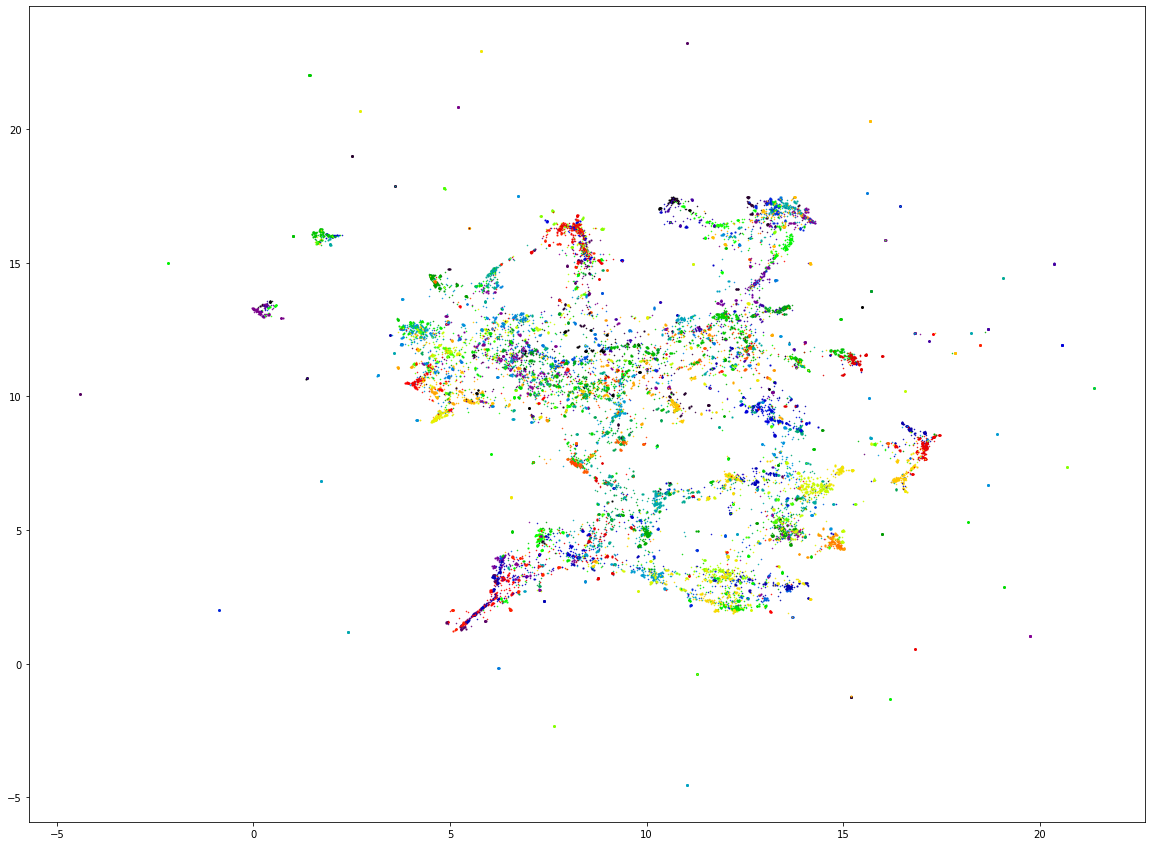

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=91
INFO:root:embedding dimensionality is 128
INFO:root:running k-means clustering with k=100
INFO:root:embedding dimensionality is 128
INFO:root:New best accuracy! 0.15263015686074255


In [ ]:
# In the embeddings plots, the small dots represent the 1st stream, and the larger dots represent the 2nd stream
trainer.train(num_epochs=num_epochs)